In [3]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");
pyplot()

Plots.PyPlotBackend()

In [18]:
function read_fish(filename::String)
    data,header = readdlm(filename,',',header = true)
    header = header[:]
    if "year" in header
        @info "Working on a temporal data file"
        stationname = Vector{String}(data[:,findfirst(header .== "samp")]);
        obsyear = Vector{Int32}(data[:,findfirst(header .== "year")]);
    else
        @info "Working on a spatial data file"
        obsyear = undef;
    end;
    
    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "g1")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "g2")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    g4 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    
    @info "Number of data points: $(length(g1))"
    
    return obslon, obslat, obsyear, g1, g2, g3, g4
end

read_fish (generic function with 1 method)

In [19]:
fishdatadir = "/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/"
datafileS = joinpath(fishdatadir, "Fish_spa_abs.csv");
datafileT = joinpath(fishdatadir, "Fish_temp_abs.csv");

## Data reading
We use the function `read_fish` define in the module `make_benthos_products.jl`.

In [20]:
@time obslonT, obslatT, obsyearT, g1T, g2T, g3T, g4T = read_fish(datafileT);
@time obslonS, obslatS, obsyearS, g1S, g2S, g3S, g4S = read_fish(datafileS);

  1.026672 seconds (8.34 M allocations: 208.107 MiB, 11.27% gc time)


┌ Info: Working on a temporal data file
└ @ Main In[18]:5
┌ Info: Number of data points: 37595
└ @ Main In[18]:26


  0.576155 seconds (5.44 M allocations: 135.211 MiB, 2.47% gc time)


┌ Info: Working on a spatial data file
└ @ Main In[18]:9
┌ Info: Number of data points: 37739
└ @ Main In[18]:26


### Plot the data values

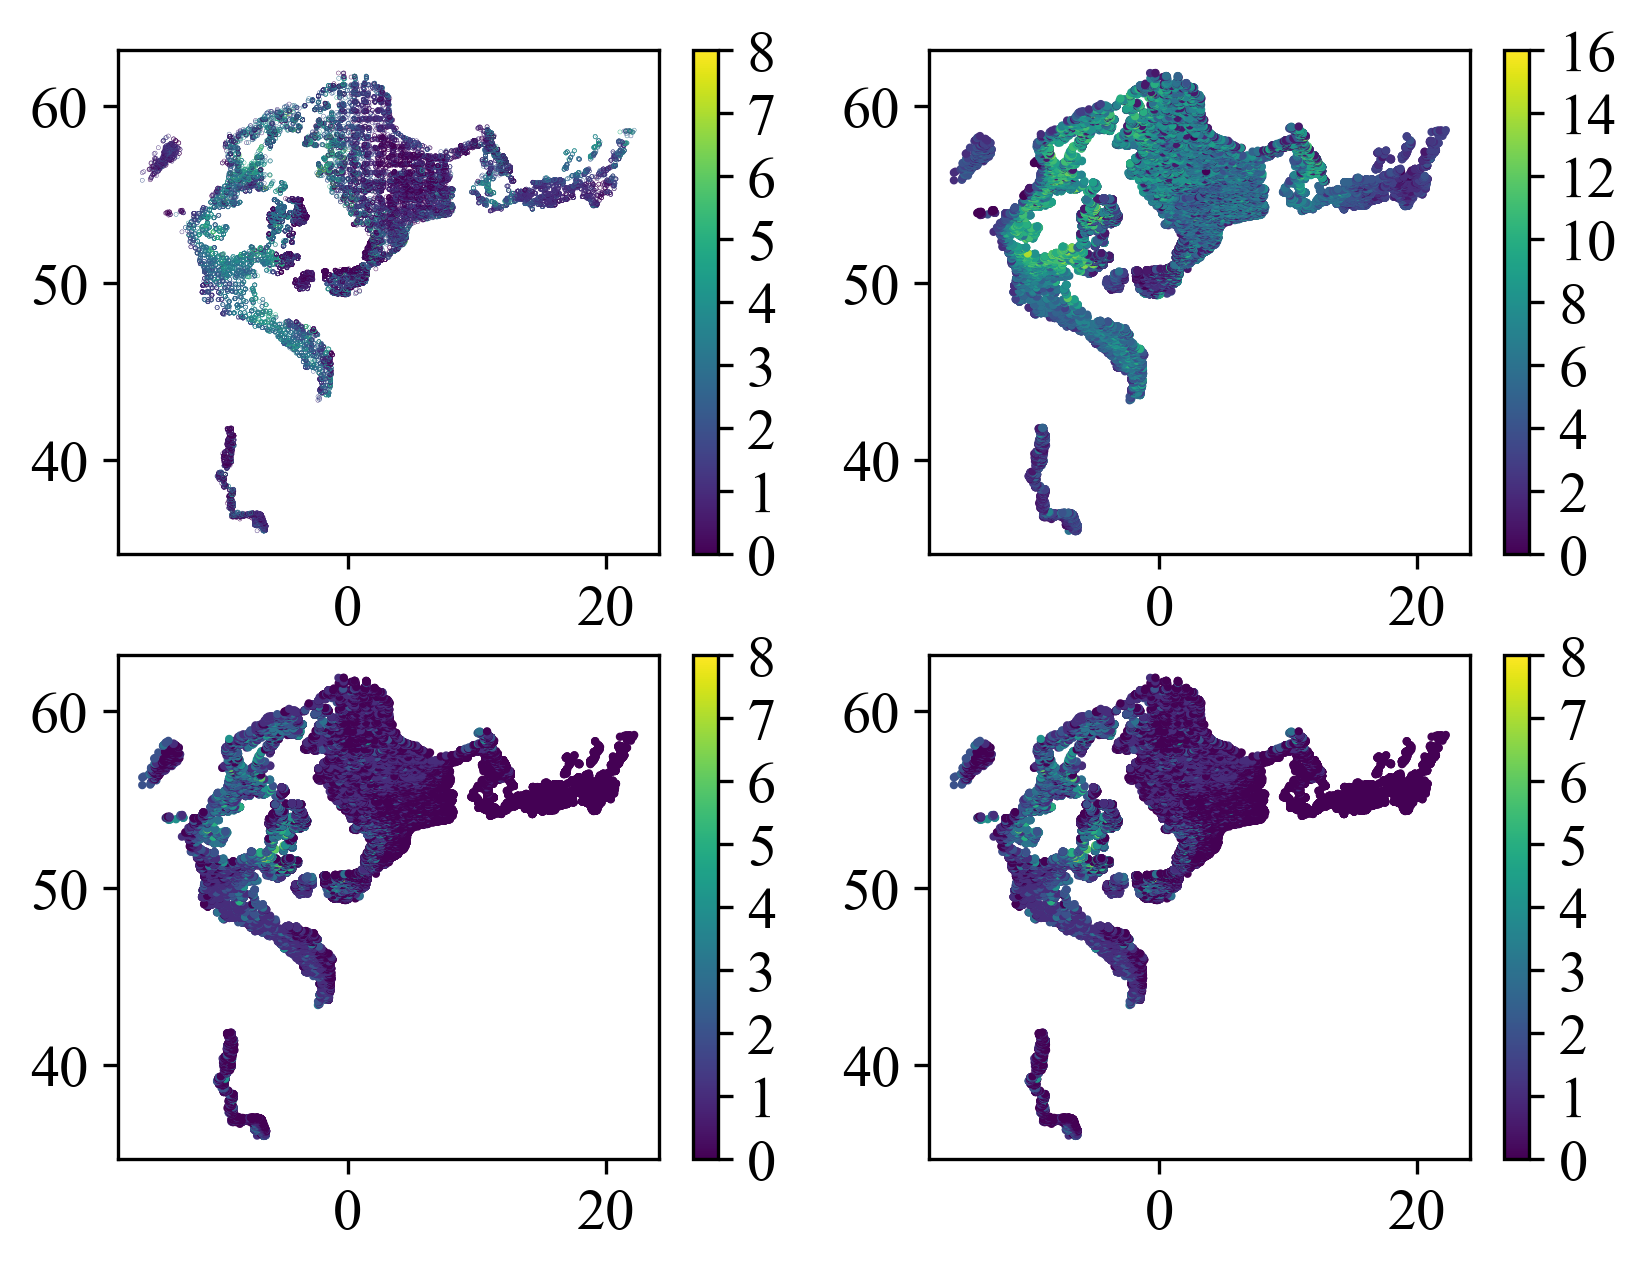

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff17a0c4b38>

In [26]:
figure()
subplot(2,2,1)
PyPlot.scatter(obslonS, obslatS, s=.01, c=g1S)
colorbar()
subplot(2,2,2)
PyPlot.scatter(obslonS, obslatS, s=1, c=g2S)
colorbar()
subplot(2,2,3)
PyPlot.scatter(obslonS, obslatS, s=1, c=g3S)
colorbar()
subplot(2,2,4)
PyPlot.scatter(obslonS, obslatS, s=1, c=g4S)
colorbar()